This code runs the simple 2D pendulum-on-a-cart simulation included in the thesis

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import scipy.integrate as integrate
from matplotlib.patches import Rectangle
from numpy import sin, cos, sign, pi
from scipy.integrate import solve_ivp
import scipy.linalg as sc

%matplotlib notebook

In [2]:
#Model parameters
L=1
M = 0.5  #kg
m = 0.3  #kg
g = 9.82

N = 30   #Horizon

Q = np.diag([10, 0, 10, 0])  #State cost matrix
R = np.diag([0.1])           #Input cost matrix

dt = 0.05   #Time step, delta t
Tmax = 28   #How long to simulate
t_span = (0, Tmax)

# Initial conditions
x0 = 0  
x0_dot = 0 
theta0 = np.pi - 0.1
theta0_dot = 0   
state_init = np.array([x0, x0_dot, theta0, theta0_dot])

In [3]:
#Matrices, as described in the thesis
A = np.array([
        [0.0, 1.0, 0.0,           0.0],
        [0.0, 0.0, -m*g/M,         0.0],
        [0.0, 0.0, 0.0,           1.0],
        [0.0, 0.0, g*(M+m)/(L*M), 0.0]
    ])

B = np.array([
        [0.0],
        [1.0/M],
        [0.0],
        [-1.0/(L*M)]
    ])
A = sc.expm(A*dt)
B = integrate.quad_vec(lambda x: sc.expm(A*x)@B, 0, dt)[0]

In [4]:
#SWING UP energy-based

def energy(theta, theta_dot):
    return M*(theta_dot**2)*(L**2)/2 + M*g*L*(cos(theta) - 1)       #Kinetic + potential energy

def derivatives(t,state):
    #Compute derivatives which will be integrated to create the state vector
    x,x_dot,theta,theta_dot = state

    E = energy(theta, theta_dot)
    u = 0.08 * E * theta_dot * cos(theta)

    derivatives = np.array([x_dot, u, theta_dot, (g*sin(theta) - u*cos(theta))/L])
    return derivatives

def stop_criterion(t, state):         #When to switch to MPC
    _,_,theta,theta_dot = state
    return (abs(theta) < np.pi/6)*1 - 1

stop_criterion.terminal = True  #Ensures the solver stops when event occurs
stop_criterion.direction = 0   

In [5]:
#STABILIZE with MPC

def MPC(init):
    x = cp.Variable((4, N+1))
    u = cp.Variable((1, N))
    epsilon = cp.Variable()

    cost = 0.0
    constr = [x[:, 0] == init[:, 0]]
    for k in range(N):
        cost += cp.quad_form(x[:, k+1], Q) + cp.quad_form(u[:, k], R) + epsilon**2
        constr += [x[:, k+1] == A @ x[:, k] + B @ u[:, k]]
        constr += [cp.norm(x[2, k], 'inf') <= np.pi/2 + epsilon]         #Constraint for theta
        constr += [cp.norm(u[:, k], 'inf') <= 5 + epsilon]               #Constraint for u

    prob = cp.Problem(cp.Minimize(cost), constr)
    prob.solve(verbose=False)

    if prob.status == cp.OPTIMAL:
        ou = np.array((u.value[0, :])).flatten()[0]
    else:
        ou = None

    return ou          #Output u is only the first value out of the N computed u values

In [6]:
def create_state_vector():
    
    #Swing up state_vector
    solution = solve_ivp(derivatives, t_span, state_init, events=stop_criterion, max_step=dt)
    state_vector = solution.y.T.tolist()
    
    #Switch to MPC
    for i in range(len(solution.t), int(Tmax/dt)):
        state = np.array(state_vector[i-1]).reshape(-1,1)
        u = MPC(state)
        state = np.dot(A, state) + np.dot(B, u)            #Update the state according to the model
        state_vector.append(state.flatten())
           
    state_vector = np.array(state_vector)
    return state_vector

In [7]:
#Animation function, to be called by FuncAnimation below
def animate(i):
    thisx = [xs[i], x_rod[i]]
    thisy = [0, y_rod[i]]

    line.set_data(thisx, thisy)
    cart.set_x(xs[i] - size/2)
    
    text.set_text(thetas[i])

    return line, cart

In [8]:
#Create state vector
state_vector = create_state_vector()

In [9]:
thetas = state_vector[:, 2]
xs = state_vector[:, 0]

x_rod = xs + sin(thetas)*L
y_rod = cos(thetas)*L

<IPython.core.display.Javascript object>


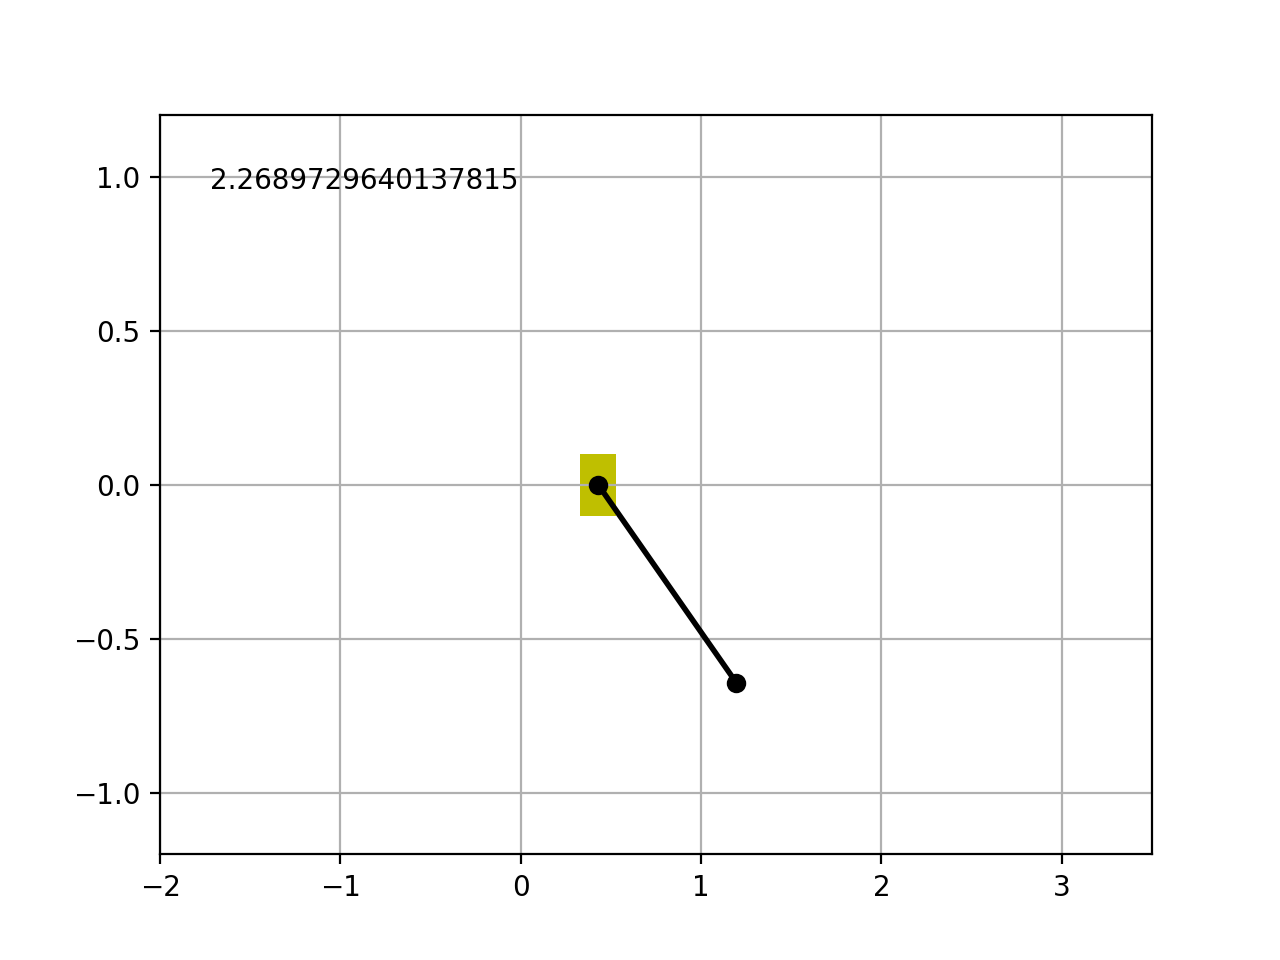

In [14]:
#Animate the pendulum on the cart
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 3.5), ylim=(-1.2, 1.2))
ax.grid()

#The text now displays the theta angle
text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
text.set_text('')

size = 0.2
cart = ax.add_patch(Rectangle((-size / 2, -size / 2), size, size, linewidth=1, facecolor='y'))
line, = ax.plot([], [], 'o-', lw=2, color='black')

ani = FuncAnimation(fig, animate, frames=int(Tmax/dt), interval=10, blit=True, repeat=False)
plt.show()

In [11]:
#Count the pendulum angle clockwise starting from the upward position

for i in range(len(state_vector)):
    if state_vector[:,2][i] > pi:
        state_vector[:,2][i] -= 2*pi

<IPython.core.display.Javascript object>


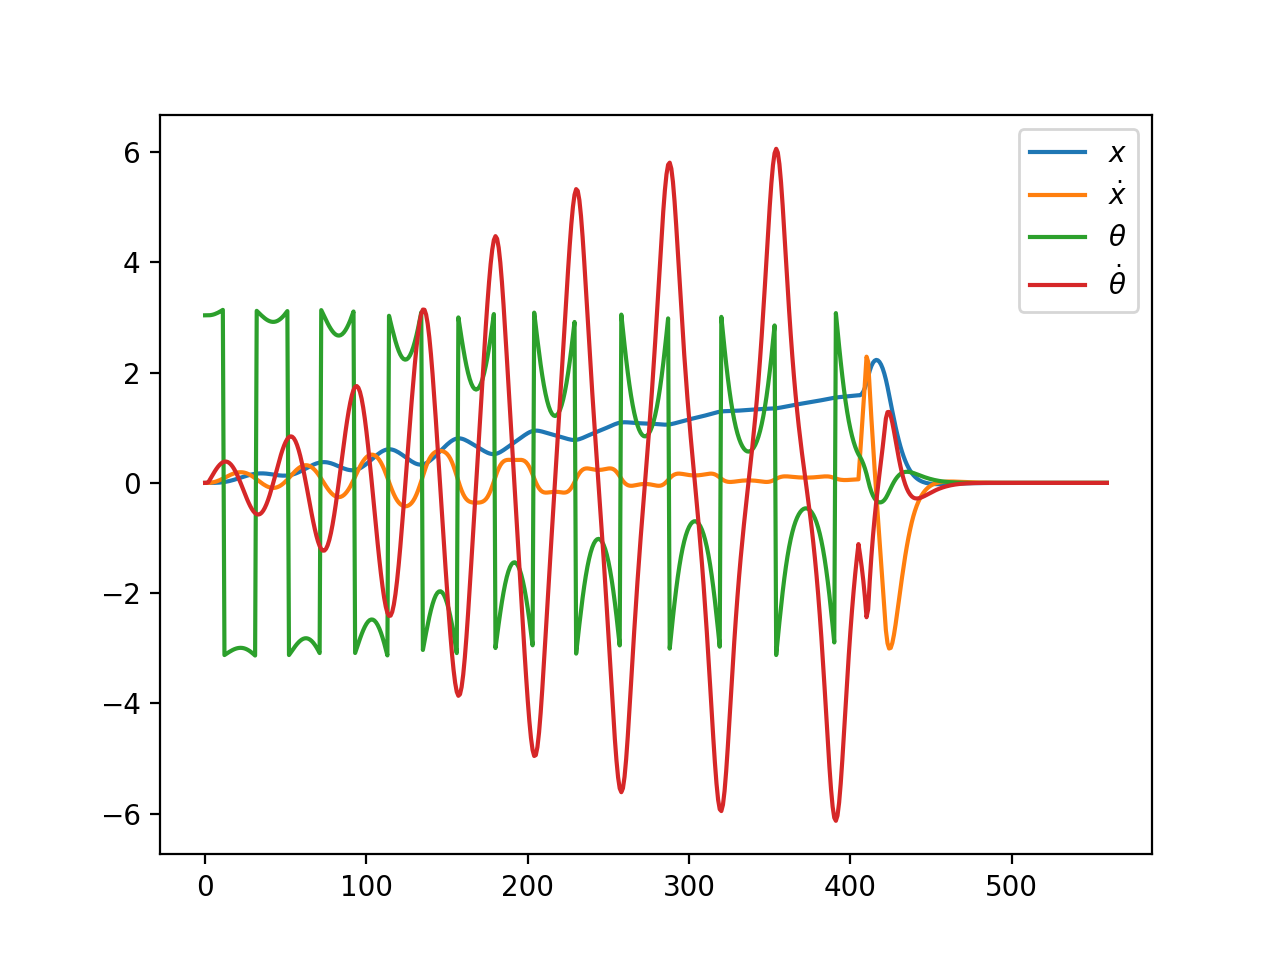

In [13]:
#This cell generates the plot included in the thesis
#Beware: if you run all cells, this plot may end up in the animation above

plt.plot(state_vector)
plt.legend(["$x$", "$\\dot{x}$", '$\\theta$', "$\\dot{\\theta}$"])
plt.show()